In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import ReduceLROnPlateau, Callback
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

In [2]:
data_dir = "C:\\Users\\Ahmet Berkay\\Desktop\\efficientnet2\\calcification-mass"

In [3]:
img_height,img_width=512,512
batch_size=4
ds_train = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical')

Found 2696 files belonging to 2 classes.
Using 2157 files for training.


In [4]:
ds_val = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical')

Found 2696 files belonging to 2 classes.
Using 539 files for validation.


In [5]:
class_names = ds_train.class_names
print(class_names)

['calcification', 'mass']


In [6]:
# Sınıf dağılımını hesaplayın
class_counts = np.zeros(len(class_names))
for images, labels in ds_train:
    class_counts += np.sum(labels.numpy(), axis=0)

# Sınıf ağırlıklarını hesaplayın
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(class_names)),
    y=np.concatenate([np.argmax(labels.numpy(), axis=1) for _, labels in ds_train])
)

class_weights = {i: class_weights[i] for i in range(len(class_names))}
print(f"Class weights: {class_weights}")

Class weights: {0: 1.473360655737705, 1: 0.7568421052631579}


In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
# Load EfficientNetB3 base model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Unfreeze the top layers of the model
for layer in base_model.layers[-2:]:  # Unfreeze the top 5 layers
    layer.trainable = True

# Build new Sequential model
efficient_net = Sequential()
efficient_net.add(base_model)
efficient_net.add(GlobalAveragePooling2D())
efficient_net.add(Dense(128, activation='relu'))
efficient_net.add(Dropout(0.5))
efficient_net.add(Dense(len(class_names), activation='softmax'))

# Compile the model
efficient_net.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

efficient_net.summary()
# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 16, 16, 1280)     4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 4,213,797
Trainable params: 4,171,774
Non-trainable params: 42,023
_________________________________________

In [8]:
import os
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import precision_score, recall_score, f1_score

# Define the F1 score callback
class MetricsCallback(Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data
        self.metrics = []

    def on_epoch_end(self, epoch, logs=None):
        val_predict = np.argmax(self.model.predict(self.validation_data), axis=1)
        val_targ = np.concatenate([np.argmax(y, axis=1) for _, y in self.validation_data])

        precision = precision_score(val_targ, val_predict, average='weighted')
        recall = recall_score(val_targ, val_predict, average='weighted')
        f1 = f1_score(val_targ, val_predict, average='weighted')

        self.metrics.append({'epoch': epoch + 1, 'precision': precision, 'recall': recall, 'f1': f1})
        print(f" — val_precision: {precision}, val_recall: {recall}, val_f1: {f1}")

# Define the directory path for saving metrics.txt and model weights
output_dir = "C:\\Users\\Ahmet Berkay\\Desktop\\efficientnet2"

# Define the file path for saving the model weights
model_weights_path = os.path.join(output_dir, "model_weights_best_f1.h5")
# Define the file path for saving the metrics
metrics_file_path = os.path.join(output_dir, "metrics.txt")

class CustomModelCheckpoint(Callback):
    def __init__(self, file_path):
        super().__init__()
        self.file_path = file_path
        self.best_f1 = 0

    def on_epoch_end(self, epoch, logs=None):
        val_f1 = logs.get('val_f1')
        if val_f1 is None:
            return

        if val_f1 > self.best_f1:
            self.best_f1 = val_f1
            file_path = self.file_path.format(epoch=epoch + 1, f1=val_f1)
            self.model.save_weights(file_path)
            print(f" — Saved model weights with val_f1: {val_f1:.4f} to {file_path}")

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
metrics_callback = MetricsCallback(ds_val)
model_checkpoint = CustomModelCheckpoint(model_weights_path)


In [9]:
# Train the model
epochs = 25
history = efficient_net.fit(
    ds_train,
    validation_data=ds_val,
    epochs=epochs,
    class_weight=class_weights,
    callbacks=[reduce_lr, metrics_callback, model_checkpoint]
)

# Save the metrics to the file
with open(metrics_file_path, 'w') as file:
    for metric in metrics_callback.metrics:
        file.write(f"Epoch: {metric['epoch']}, Precision: {metric['precision']}, Recall: {metric['recall']}, F1: {metric['f1']}\n")
efficient_net.save_weights(model_weights_path)

Epoch 1/25
135/135 [==============================] - 6s 34ms/step
 — val_precision: 0.5399175140396336, val_recall: 0.5584415584415584, val_f1: 0.5471540426193237
540/540 [==============================] - 94s 150ms/step - loss: 0.5790 - accuracy: 0.7038 - val_loss: 0.5138 - val_accuracy: 0.8033 - lr: 1.0000e-04
Epoch 2/25
135/135 [==============================] - 5s 35ms/step
 — val_precision: 0.5220563138884183, val_recall: 0.5584415584415584, val_f1: 0.5337240431072885
540/540 [==============================] - 79s 147ms/step - loss: 0.4577 - accuracy: 0.7867 - val_loss: 0.4744 - val_accuracy: 0.7996 - lr: 1.0000e-04
Epoch 3/25
135/135 [==============================] - 5s 34ms/step
 — val_precision: 0.5083396992128871, val_recall: 0.5287569573283859, val_f1: 0.5167106169130596
540/540 [==============================] - 79s 147ms/step - loss: 0.3860 - accuracy: 0.8289 - val_loss: 0.6120 - val_accuracy: 0.8553 - lr: 1.0000e-04
Epoch 4/25
135/135 [==============================] - 5

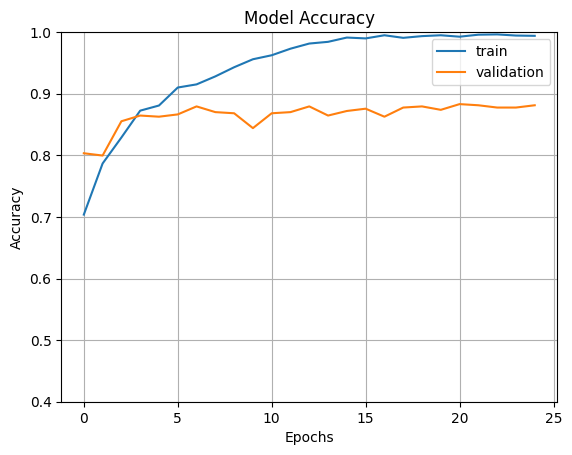

In [10]:
import matplotlib.pyplot as plt
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

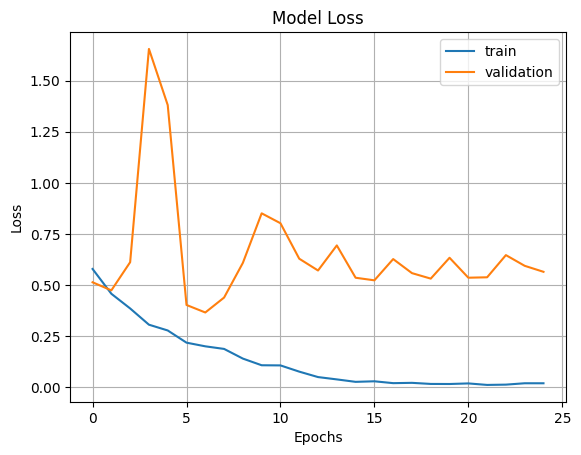

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

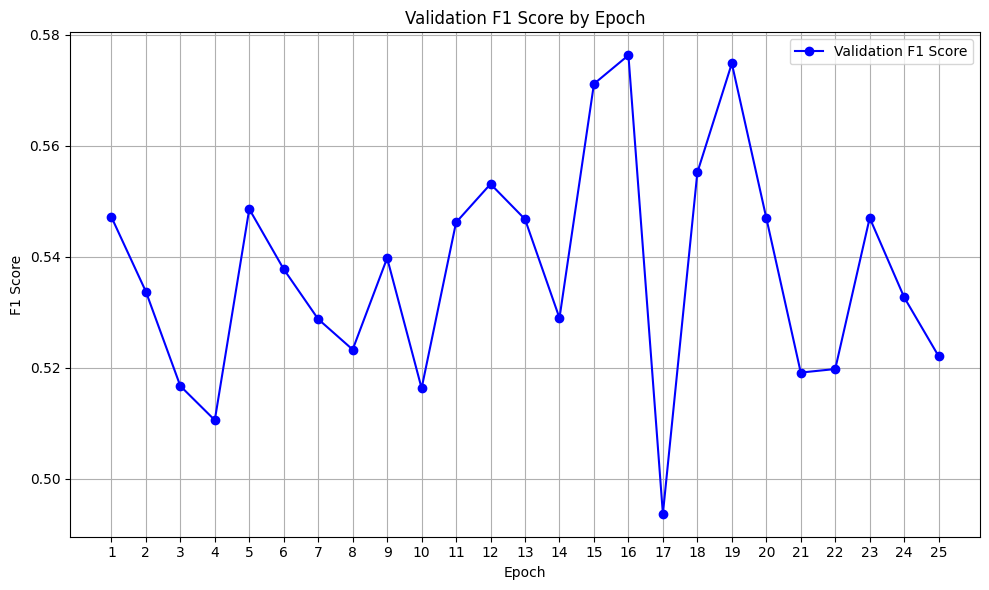

In [13]:
import matplotlib.pyplot as plt

# Assuming metrics_callback.metrics contains the metrics collected during training

epochs = range(1, len(metrics_callback.metrics) + 1)
f1_scores = [metric['f1'] for metric in metrics_callback.metrics]

plt.figure(figsize=(10, 6))
plt.plot(epochs, f1_scores, marker='o', linestyle='-', color='b', label='Validation F1 Score')
plt.title('Validation F1 Score by Epoch')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

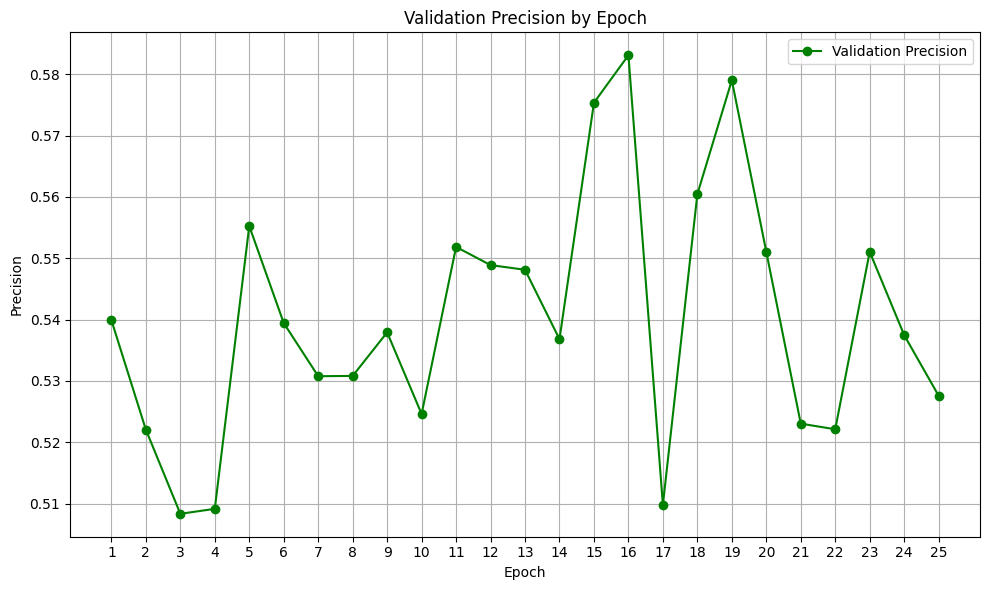

In [14]:
import matplotlib.pyplot as plt

# Assuming metrics_callback.metrics contains the metrics collected during training

epochs = range(1, len(metrics_callback.metrics) + 1)
precisions = [metric['precision'] for metric in metrics_callback.metrics]

plt.figure(figsize=(10, 6))
plt.plot(epochs, precisions, marker='o', linestyle='-', color='g', label='Validation Precision')
plt.title('Validation Precision by Epoch')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

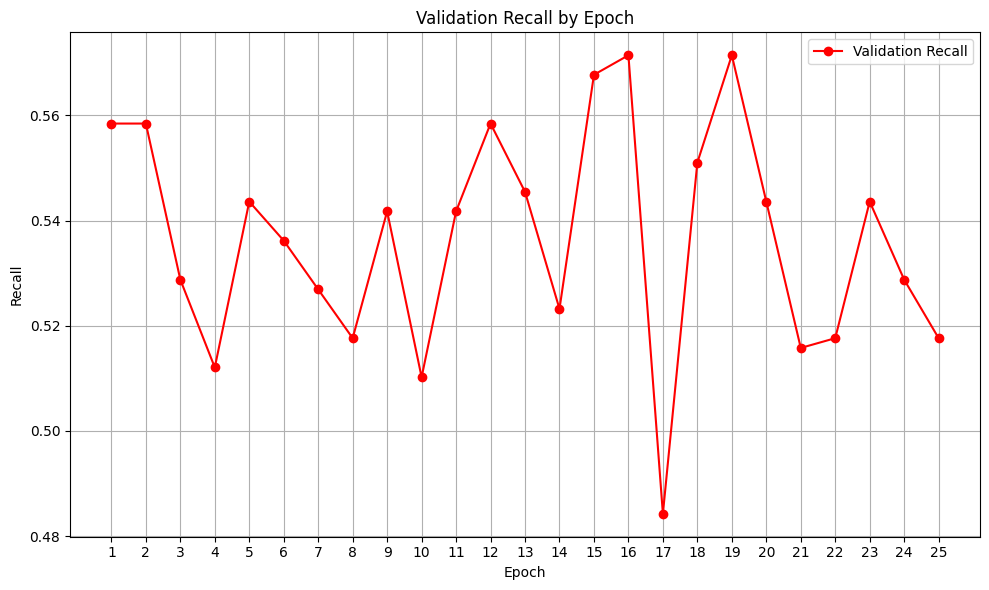

In [15]:
import matplotlib.pyplot as plt

# Assuming metrics_callback.metrics contains the metrics collected during training

epochs = range(1, len(metrics_callback.metrics) + 1)
recalls = [metric['recall'] for metric in metrics_callback.metrics]

plt.figure(figsize=(10, 6))
plt.plot(epochs, recalls, marker='o', linestyle='-', color='r', label='Validation Recall')
plt.title('Validation Recall by Epoch')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
#############################################################################################################################
#VERİSETİNİ AYARLAMA KISMI
#############################################################################################################################
#BURDAKİ OLAY ÖNCEKİ MODELDEKİ KODLA BİRADS İÇİN RESİMLERİ KIRPIYORUM SONRA BİRADS İÇİN RESİMLERİ KAYDETTİĞİM YERDEN RESİMLERİ KALSİFİKASYON/MASS LABELLARINA GÖRE ÇEKİYORUM.
#VE YENİ VERİ SETİNİ KAYDEDİYORUM.
#############################################################################################################################
import os
import shutil

# Dosya ve klasör yolları
txt_folder_path = r"C:\\Users\\Ahmet Berkay\Desktop\\mass_cacification_labels\\mass_calcification"
base_png_folder_path = r"C:\\Users\\Ahmet Berkay\Desktop\\YOLO_format\data\\new_pTrain2\\newTrain\\new_train"
destination_base_path = r"C:\\Users\\Ahmet Berkay\Desktop\\efficientnet2\\calcification-mass"

# Hedef klasörler
calcification_folder = os.path.join(destination_base_path, "calcification")
mass_folder = os.path.join(destination_base_path, "mass")

# Hedef klasörleri oluştur
os.makedirs(calcification_folder, exist_ok=True)
os.makedirs(mass_folder, exist_ok=True)

# Alt klasörler
category_folders = {
    'Kategori2': 'birads2',
    'Kategori4': 'birads4',
    'Kategori5': 'birads5'
}

# Metin dosyalarının ve PNG dosyalarının işlenmesi
for txt_filename in os.listdir(txt_folder_path):
    if txt_filename.endswith(".txt"):
        txt_file_path = os.path.join(txt_folder_path, txt_filename)
        
        with open(txt_file_path, 'r') as file:
            labels = file.readlines()
            labels = [label.strip() for label in labels]
        
        base_name = txt_filename.replace(".txt", "")
        category_key = base_name.split('_')[0]  # Kategori anahtarını belirle
        
        if category_key in category_folders:
            png_folder_path = os.path.join(base_png_folder_path, category_folders[category_key])
            
            for i, label in enumerate(labels):
                png_filename = f"{base_name}_{i}D.png"
                png_file_path = os.path.join(png_folder_path, png_filename)
                
                if os.path.exists(png_file_path):
                    if label == '0':
                        destination_path = os.path.join(calcification_folder, png_filename)
                        shutil.move(png_file_path, destination_path)
                        print(f"Taşınıyor: {png_file_path} -> {destination_path}")
                    elif label == '1':
                        destination_path = os.path.join(mass_folder, png_filename)
                        shutil.move(png_file_path, destination_path)
                        print(f"Taşınıyor: {png_file_path} -> {destination_path}")
                    else:
                        print(f"Beklenmeyen etiket: {label} dosya: {png_filename}")
                else:
                    print(f"Dosya bulunamadı: {png_file_path}")

print("Taşıma işlemi tamamlandı.")


Taşıma işlemi tamamlandı.
